_Lambda School Data Science, Unit 2_
 
# Regression 1 Sprint Challenge

Your Sprint Challenge has two parts.

To demonstrate mastery on each part, do all the required, numbered instructions. 

To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Predict avocado sales 🥑

For part 1 of your challenge, you'll use historical data on avocado sales across the nation!

Run this code cell to load the dataset. It has weekly sales volume (total number of avocados sold) from January 4, 2015 through March 25, 2018. The data comes directly from retailers' cash registers based on actual retail sales of Hass avocados in multiple US markets.

In [1]:
import pandas as pd
avocado_url = 'https://drive.google.com/uc?export=download&id=1ljE-LhCA9CCFvSIJYJ1ewX8JmdDpfuhi'
avocado = pd.read_csv(avocado_url)
assert avocado.shape == (169, 2)

In [18]:
df = avocado.rename(columns={'Date':'ds', 'Total Volume':'y' })
df['ds'] = pd.to_datetime(df['ds'])
df.tail(5)

,ds,y
164,2018-02-25,109231389
165,2018-03-04,111844876
166,2018-03-11,111465145
167,2018-03-18,113673928
168,2018-03-25,118268903


### Required

#### Use the Prophet library to:
1. Fit a model and forecast avocado sales through March 25, 2020
2. Plot the forecast
3. Plot the forecast components
4. Do time series cross-validation, with these parameters: `horizon='90 days', period='45 days', initial='730 days'`
5. Plot the cross-validation Mean Absolute Percentage Error: `metric='mape'`

_For Part 1 of this Sprint Challenge, you are **not** required to calculate or plot baselines, or do train/test split._

You can be confident you've done it correctly when your plots look similar to these:

<img src="https://i.imgur.com/PoyVGp7.png" width="400" align="left">



### Stretch Goal
- Adjust your forecasts with Prophet's options for changepoints, holidays, and fourier order. Improve the cross-validation MAPE.

In [2]:
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [23]:
model = Prophet(weekly_seasonality=True)
model.fit(df)
future = model.make_future_dataframe(periods=731)
forecast = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


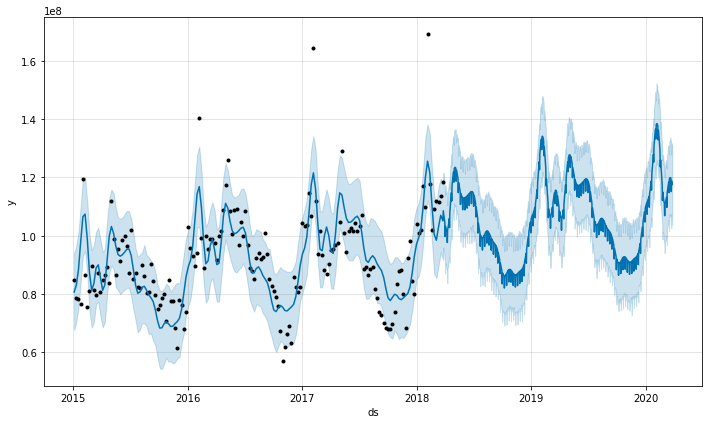

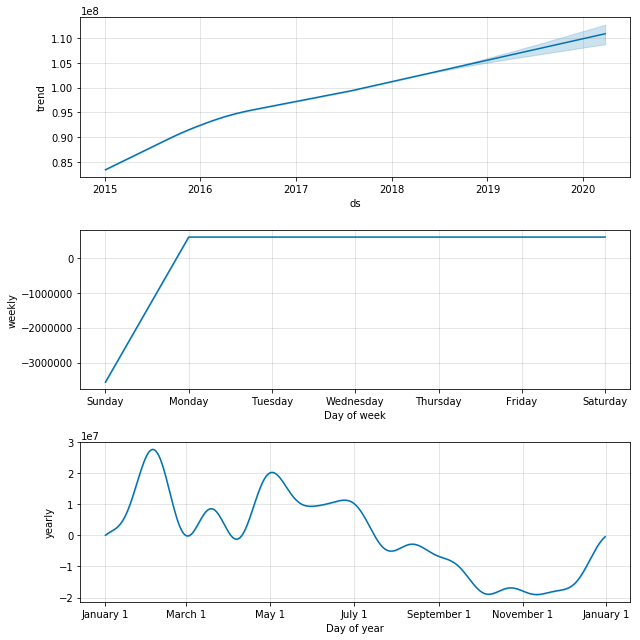

In [27]:
model.plot(forecast);
model.plot_components(forecast);

In [31]:
from fbprophet.diagnostics import cross_validation

cv = cross_validation(model, horizon='90 days', period='45 days', initial='730 days')

INFO:fbprophet:Making 8 forecasts with cutoffs between 2017-02-13 00:00:00 and 2017-12-25 00:00:00
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/anaconda3/lib/python3.7/site-package

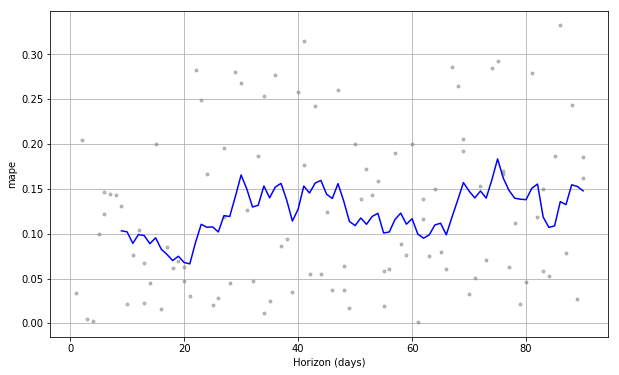

In [33]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(cv, metric='mape')

## Part 2. Predict NYC apartment rent 🏠💸

For part 1 of your challenge, you'll use a real-world data with rent prices for a subset of apartments in New York City!

Run this code cell to load the dataset: 

In [37]:
import pandas as pd
rent_url = 'https://drive.google.com/uc?export=download&id=1lVVPmh-WYGb_0Gs_lOv22i02-150qDdZ'
rent = pd.read_csv(rent_url)
assert rent.shape == (48295, 7)

rent.head(2)

,year,month,bedrooms,bathrooms,latitude,longitude,price
0,2016,6,3,1.5,40.7145,-73.9425,3000
1,2016,6,2,1.0,40.7947,-73.9667,5465


In [105]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from math import sqrt

rent['mean_baseline'] = rent['price'].mean()
y_true = rent['price']
y_pred = rent['mean_baseline']

mean_absolute_error(y_true, y_pred), r2_score(y_true, y_pred)

(1055.7857771080928, 0.0)

In [106]:
train = [4, 5]
test = [6]

train_df = rent[rent['month'].isin(train)]
test_df = rent[rent['month'].isin(test)]

assert train_df.shape[0] + test_df.shape[0] == rent.shape[0]

In [107]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [110]:
features = rent.columns.values[:6].tolist()
target = 'price'

num_f = len(features) - 1
attempts=[]

x = 0
while (x < num_f):
    y = x + 1
    while (y <= num_f):
        X_train = train_df[[features[x], features[y]]]
        y_train = train_df[target]
        X_test = test_df[[features[x], features[y]]]
        y_test = test_df[target]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        attempts.append({'features': (features[x], features[y]),
                     'mae': mae, 'r2': r2, 'rmse':rmse, 'coef':model.coef_,
                         'intercept': model.intercept_
                    })
        y += 1
    x += 1
    
pd.DataFrame(attempts).sort_values(by=['mae', 'r2']).set_index('features')


,coef,intercept,mae,r2,rmse
features,,,,,
"(bathrooms, longitude)","[2060.260758323319, -14242.71584177047]",-1.052567e+06,751.357650,0.477604,1016.153307
"(bedrooms, bathrooms)","[420.50971680243293, 1531.7626475309758]",9.943063e+02,754.073304,0.461358,1031.832330
"(bedrooms, longitude)","[745.4390525550731, -16182.696334295122]",-1.194760e+06,767.873839,0.409459,1080.398945
"(bathrooms, latitude)","[2083.0085566956964, -2737.511088219884]",1.125305e+05,820.273184,0.392550,1095.758010
"(year, bathrooms)","[0.0, 2084.3548668828903]",9.732192e+02,826.141138,0.388565,1099.345499
"(month, bathrooms)","[32.08805787574678, 2084.001265382288]",8.295508e+02,831.332111,0.388734,1099.193954
"(bedrooms, latitude)","[725.3730484549261, -2740.622878813895]",1.140268e+05,857.719139,0.298459,1177.567432
"(year, bedrooms)","[0.0, 725.9451336882962]",2.343441e+03,865.621107,0.295150,1180.341539
"(month, bedrooms)","[32.174707141008675, 725.7914585835908]",2.199197e+03,872.223616,0.293902,1181.386080


### Required
1. Begin with baselines for regression. Calculate the mean absolute error and $R^2$ score for a mean baseline. _(You can use the whole dataset, or a test set, either way is okay here!)_
2. Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
3. Choose any two features.
4. Use scikit-learn to fit a Linear Regression model on the train data.
5. Apply the model to predict rent prices for the test data.
6. Get regression metrics MAE and $R^2$ for the test data.
7. Get the model's coefficients and intercept.

### Stretch Goals
- Try at least 3 different feature combinations. (You don't have to use two features, you can choose any number of features.)
- Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.